In [4]:
import lsst.daf.base as dafBase
import lsst.daf.persistence as dafPersist
import lsst.afw.table as afwTable
import lsst.afw.geom as afwGeom
import Utils.DiaSourceTools as DSTools

In [5]:
DATADIR="/renoir_data_02/jpreyes/lsst_data/CFHTLS_master/output/classTest"
butler = dafPersist.Butler(DATADIR)

In [6]:
def multi_match_catalogs(catalog_list, data_refs):
    multi_matches = None

    for catalog, (visit, ccd) in zip(catalog_list, data_refs):

            if multi_matches is None and len(catalog)>0:
                multi_matches = afwTable.MultiMatch(catalog[0].schema, {'visit':int, 'ccd':int}, radius=afwGeom.Angle(1./3600., afwGeom.degrees))
            if multi_matches is not None:
                multi_matches.add(catalog, {'visit':int(visit), 'ccd':int(ccd)})

    results = multi_matches.finish(removeAmbiguous=False)  
    return results

In [7]:
data_refs = butler.queryMetadata("deepDiff_class_diaSrc", format=['visit', 'ccd'], dataId={'filter':'r'})
def_data_refs = []
catalogs = []
for data_ref in data_refs:
    if butler.datasetExists("deepDiff_class_diaSrc", dataId={'visit':data_ref[0], 'ccd':data_ref[1], 'filter':'r'}):
        catalog = butler.get("deepDiff_class_diaSrc", dataId={'visit':data_ref[0], 'ccd':data_ref[1], 'filter':'r'})
        catalogs.append(catalog)
        def_data_refs.append(data_ref)
        


In [8]:
results = multi_match_catalogs(catalogs, def_data_refs)

In [9]:
light_curves=DSTools.get_light_curves_from_multimatch_results2(results)
print len(light_curves)

287100


In [10]:
lcs = []
for t_light_curve in light_curves:
    lcs.append(DSTools.build_lightcurve2(t_light_curve, "base_CircularApertureFlux_3_0_flux"))

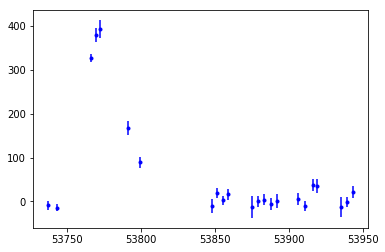

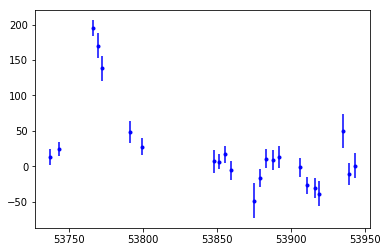

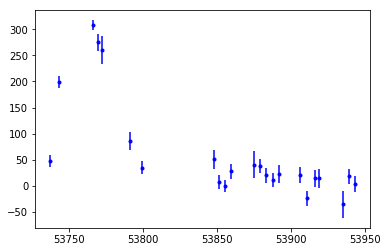

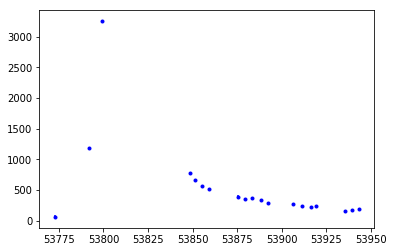

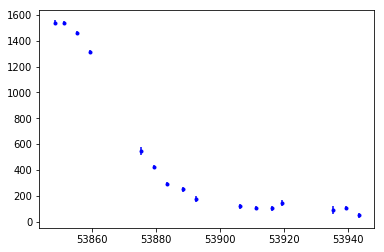

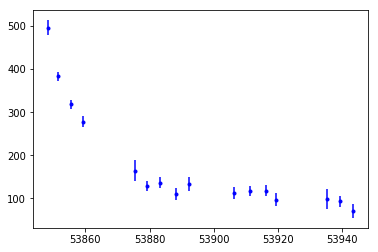

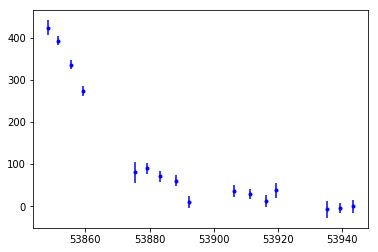

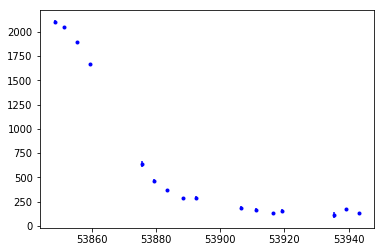

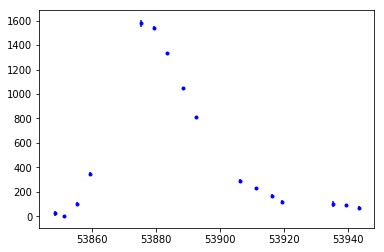

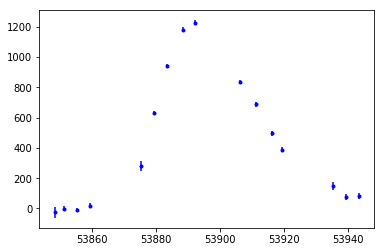

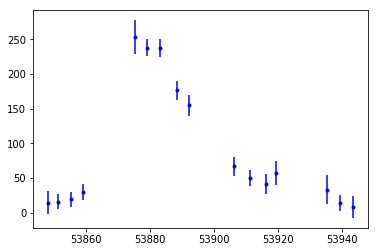

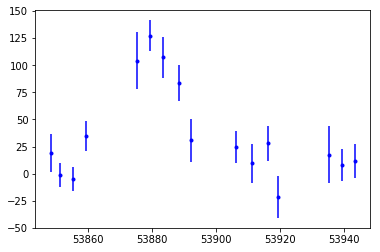

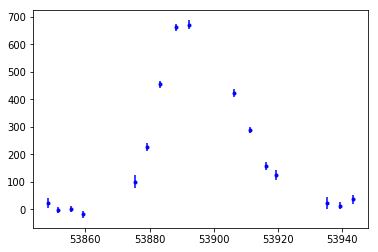

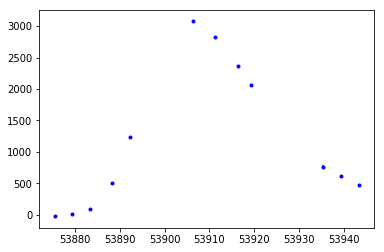

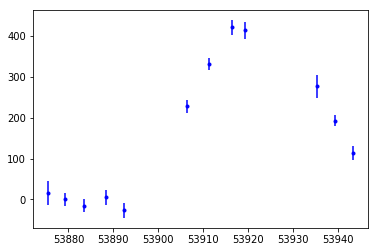

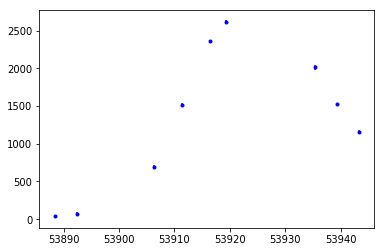

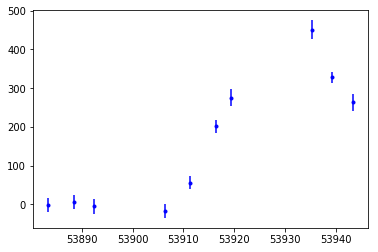

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import re
import astropy.coordinates as coord
import astropy.units as u

filter='r'

f = open('/renoir_data_02/jpreyes/lsst_data/sn_control/J_A+A_523_A7_table9.dat.txt','r')
data_elems = f.read()
elems = re.findall('^(06D3.*?)\\|(.*?)\\|', data_elems, re.MULTILINE)

f = open('/renoir_data_02/jpreyes/lsst_data/sn_control/J_A+A_523_A7_table10.dat.txt','r')
data = f.read()

snls_array = []
for sn in elems:
    c = coord.SkyCoord(sn[-1], unit=(u.hourangle, u.deg))
    
    m = re.findall('^'+str(sn[0])+'\\|('+filter+')\\|(.*?)\\|(.*?)\\|(.*?)$', data, re.MULTILINE)

    snls_lc = DSTools.build_light_curve_from_snls_file(m, c)
    plt.errorbar(snls_lc['mjd'], snls_lc['flux'], yerr=snls_lc['flux_error'], fmt='.', color='blue')
    snls_array.append(snls_lc)
    plt.show()

In [13]:
matches = DSTools.match_control_group(lcs,snls_array)
float(len(matches))/float(len(snls_array))

0.4117647058823529

In [14]:
def get_stamps_in_lc(lc):
    ccds= range(0,36)
    stamps = []
    CenterRa = np.mean(lc["ra"])
    CenterDec = np.mean(lc["dec"])
    for point in lc:



        diffExp = butler.get("deepDiff_differenceExp", dataId={"filter":'r', 'visit':point["mjd"], 'ccd':point["ccd"]})
        box = diffExp.getBBox()
        wcs = diffExp.getWcs()
        coord = afwGeom.Point2I(wcs.skyToPixel(CenterRa, CenterDec))
        #calexp = butler.get("calexp", dataId={"filter":'r', 'visit':point["mjd"], 'ccd':ccd})
        calexp = butler.get("calexp", dataId={"filter":'r', 'visit':point["mjd"], 'ccd':point["ccd"]})



        Center = afwGeom.Point2I(wcs.skyToPixel(CenterRa, CenterDec))
        Begin = afwGeom.Point2I(Center.getX() - 15, Center.getY() - 15)
        End = afwGeom.Point2I(Center.getX() + 15, Center.getY() + 15)

        newBox = afwGeom.Box2I(Begin,End) 
        try:
            cal_stamp = calexp.Factory(calexp, newBox, True)
            stamp = diffExp.Factory(diffExp,newBox, True)
            stamps.append((stamp, cal_stamp))
        except Exception, e:
            print e
            stamps.append((None, None))
            pass
        
    return stamps

In [15]:
supernovae = []
for match in matches:
    
    supernovae.append(match[0])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

for sn in supernovae:
    print "new supernova"
    stamps = get_stamps_in_lc(sn)
    show_stamps(sn, stamps)

In [18]:
sn

mjd,classification,zpsys,flux,ra,flux_error,ccd,dec,zp,bandpass
int64,float64,str2,float64,object,float64,int64,object,float64,str5
836493,6.0,ab,5000.46533203,3.74261 rad,170.170501709,33,0.913877 rad,25.0,sdssr
836498,6.0,ab,5263.61474609,3.74261 rad,173.452804565,33,0.913878 rad,25.0,sdssr
838855,6.0,ab,3815.13378906,3.74261 rad,156.277359009,33,0.913879 rad,25.0,sdssr
839309,0.0,ab,990.508728027,3.74261 rad,182.833114624,33,0.913882 rad,25.0,sdssr
839312,0.0,ab,2758.9296875,3.74261 rad,163.172225952,33,0.913882 rad,25.0,sdssr
844845,3.0,ab,4316.91455078,3.74261 rad,181.066848755,33,0.913875 rad,25.0,sdssr
844848,0.0,ab,1315.87854004,3.74261 rad,187.798431396,33,0.913877 rad,25.0,sdssr
844849,6.0,ab,12090.9912109,3.74261 rad,218.320709229,33,0.913879 rad,25.0,sdssr
849373,6.0,ab,5479.10058594,3.74261 rad,202.808700562,33,0.913879 rad,25.0,sdssr


In [16]:
def show_stamps(lc, stamps):
    i=0
    fig = plt.figure(figsize=(10,5*len(stamps)))
    for point, (stamp, c_stamp) in zip(lc, stamps):
        
        
        if stamp is not None:
            
            img_arr, mask_arr, var_arr = stamp.getMaskedImage().getArrays()
            c_img_arr, c_mask_arr, c_var_arr = c_stamp.getMaskedImage().getArrays()
            w,h = stamp.getWidth(), stamp.getHeight()  
            img_arr = np.nan_to_num(img_arr)
            c_img_arr = np.nan_to_num(c_img_arr)
            
            fig.add_subplot(len(stamps), 2, i+1)
            ax =plt.subplot(len(stamps), 2, i+1)
            
            ax.imshow(img_arr, origin='lower', vmin=img_arr.mean()-img_arr.std(), vmax=img_arr.max()+img_arr.std(), cmap='gray', extent=(0,w-1, 0, h-1), interpolation='none')
            ax.set_title("diff-"+str(point["mjd"])+"-"+str(point["classification"]))
            fig.add_subplot(len(stamps), 2, i+2)
            ax = plt.subplot(len(stamps), 2, i+2)
            
            ax.imshow(c_img_arr, origin='lower', vmin=c_img_arr.mean()-c_img_arr.std(), vmax=c_img_arr.max()+c_img_arr.std(), cmap='gray', extent=(0,w-1, 0, h-1), interpolation='none')
            ax.set_title("cal-"+str(point["mjd"])+"-"+str(point["classification"]))
          
            i+=2
            
    plt.show()

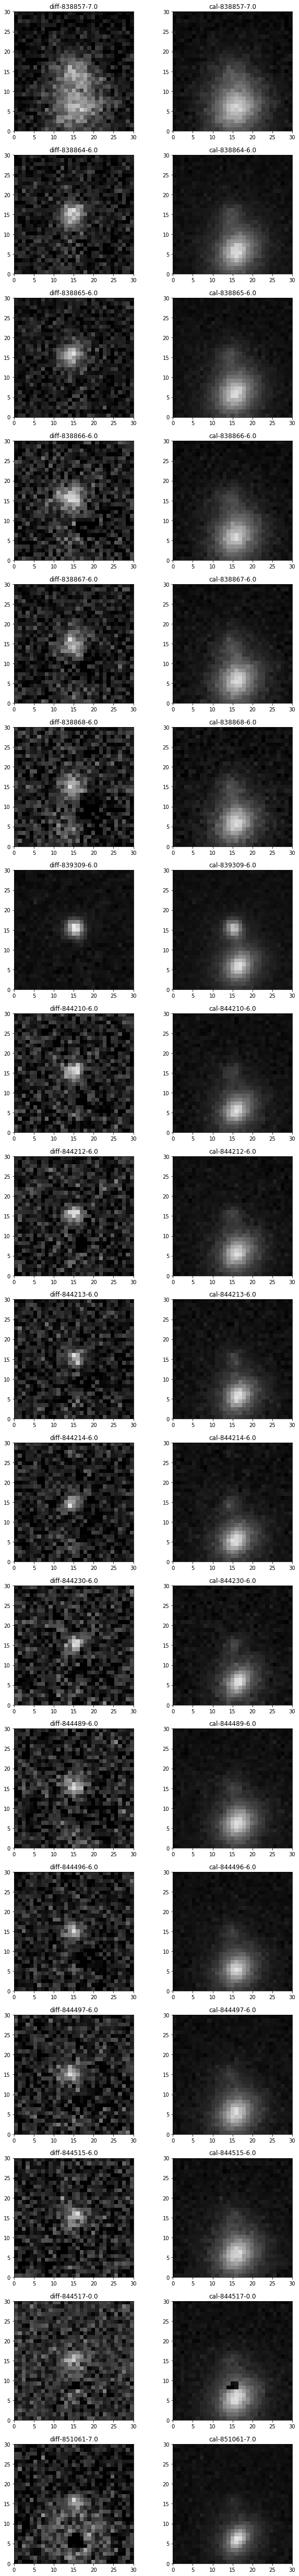

In [111]:
show_stamps(supernovae[0], stamps)